# `logikon`<br/>*Debugging and Scoring LLM Reasoning Traces*

This notebook demonstrates the basic usage of the `logikon` package.

* 🏖️ **SIMPLE** — Debug reasoning with one extra line of code
* 💡 **INSIGHTFUL** — Meaningful scores for assessing complex reasoning  
* ✨ **GORGEOUS** — Beautiful visualizations (e.g., argument maps)
* ↔️ **INTEGRATIONS** — Report debugging results to LLM observability platform of your choice 

<div class="alert alert-block alert-warning">
<b>Important notice.</b> <code>logikon</code> is in early development stage:
<ul>
<li> the package is subject to change at any time;
<li> debugging results can vary due to changes in debuggers, pipeline, and underlying models;
<li> current quality of debugging results is not representative of future product.
</ul>
</div>

### Set-up

In [2]:
# GH_ACCESS_TOKEN required to install `logikon` package from GitHub

import getpass
import os

GH_ACCESS_TOKEN = getpass.getpass("GH_ACCESS_TOKEN: ")
os.environ["GH_ACCESS_TOKEN"] = GH_ACCESS_TOKEN

In [ ]:
# Install `logikon` module and additional packages

# NOTE
# Resolving requirements and setting up a consistent environment for serving models
# locally can be tricky. In case you don't plan to use locally served models, we
# recommend option (B) below.

# hatch packaging
%pip install hatch

# (A) for using local models with vllm / example 3:
%pip install -U "vllm>=0.1.7" git+https://$GH_ACCESS_TOKEN@github.com/logikon-ai/logikon.git
%pip install "tokenizers==0.13.3"

# (B) no local models:
# %pip install -U git+https://$GH_ACCESS_TOKEN@github.com/logikon-ai/logikon.git


In [ ]:
# For examples 2 and 3:
# To visualize the argument map, graphviz needs to be installed.

!sudo apt install graphviz -y  # install graphviz

In [5]:
%pip list | grep pydantic

pydantic                          1.10.12
Note: you may need to restart the kernel to use updated packages.


### Imports and Api Keys

In [1]:
import getpass
import os

# For examples 1 and 2: OpenAI API key
OPENAI_API_KEY = getpass.getpass("OPENAI_API_KEY: ")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# For example 3: HuggingFace Hub API token
HUGGINGFACEHUB_API_TOKEN = getpass.getpass("HUGGINGFACEHUB_API_TOKEN: ")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [2]:
from pprint import pprint

import logikon

print(f"Installed `logikon` module version: {logikon.__version__}")

Installed `logikon` module version: 0.0.1.dev0


### Data

In [3]:
# slightly adapted from `logikon/oasst1-delib` dataset

prompt = """prompter:
I live in the US, and i am thinking of moving to Argentina.
What pro and cons you think i will have?

assistant:
"""
completion = """Here are some pros and cons to consider if you are thinking of moving to Argentina:
Pros: 
Rich culture: Argentina has a rich cultural heritage, including music, dance, literature, and art.
Beautiful natural scenery: The country has a varied geography, from the Andes mountains to the fertile plains of the Pampas, and plenty of natural parks and reserves.
Good food: Argentine cuisine is known for its grilled meats and various types of pasta, and there are many great restaurants to be found throughout the country.
Low cost of living: In comparison to the United States, the cost of living in Argentina can be quite low, especially in terms of housing and food.
Cons:
Economic instability: Argentina has a history of economic instability, with periodic devaluations of its currency, high inflation, and government default on its debt.
High crime rates: Some areas of Argentina have high crime rates, particularly in the larger cities, so it's important to be cautious and aware of your surroundings.
Language barrier: Although many people in Argentina speak some English, it's still a good idea to learn Spanish if you plan to live there, as it may be difficult to get by without it in some areas.
Distance from home: Moving to a foreign country can be a major adjustment, especially if you are far from friends and family.
These are some of the factors to consider if you're thinking of moving to Argentina.
Ultimately, the decision to move will depend on your individual circumstances and priorities."""

### Example Usage 1:<br/>Create Informal Argument Map with OpenAI (Default Configuration)

With the default configuration, `logikon.score()` just reconstructs the argumentation network (informal argument map). 

In [ ]:
config = logikon.DebugConfig()
pprint(config.model_dump())

{'artifacts': ['informal_argmap'],
 'expert_model': 'gpt-3.5-turbo-instruct',
 'expert_model_kwargs': {'temperature': 0.7},
 'generation_kwargs': None,
 'inputs': [],
 'llm_framework': 'OpenAI',
 'metrics': [],
 'report_to': []}


In [ ]:
results = logikon.score(prompt, completion, config=config)

In [ ]:
pprint(results.model_dump())

{'artifacts': [{'data': ['Yes, one should move to Argentina.'],
                'description': 'Key claims in the deliberation',
                'dtype': None,
                'id': 'claims',
                'metadata': None},
               {'data': {'edgelist': [{'source': 'f0b5c20c-d01d-4e9b-a1b1-10ce87c2281d',
                                       'target': '6f8e6819-a846-4ccf-a1ff-6b1580d84cbd',
                                       'valence': 'pro'},
                                      {'source': '5a7e6fff-614e-4915-a181-e3a941db0697',
                                       'target': '6f8e6819-a846-4ccf-a1ff-6b1580d84cbd',
                                       'valence': 'pro'},
                                      {'source': '1e278507-54ba-4f52-b511-e408d3c3d796',
                                       'target': '6f8e6819-a846-4ccf-a1ff-6b1580d84cbd',
                                       'valence': 'pro'},
                                      {'source': '6d77316f-c395-4

### Example Usage 2:<br/>Reconstruct arguments, create SVG artifact, and score basic metrics with OpenAI

In this example, `logikon` produces an SVG that visualizes the structure of the reasoning, and reports the number of reasons/claims as well as the ratio of attack relations (i.e., con arguments).

<div class="alert alert-block alert-info">
<b>Info.</b> <code>logikon</code> automatically carries out intermediary analyses and debugging steps required for obtaining desired scores and artifacts. Technically, <code>logikon.score()</code> sets up a debugger pipeline based on the <code>config</code>.
</div>

In [ ]:
config = logikon.DebugConfig(
    artifacts=["svg_argmap"],
    metrics=[
        "argmap_size",           # number of reasons
        "argmap_attack_ratio",   # number of cons / number of reasons
    ],
)

In [ ]:
results = logikon.score(prompt, completion, config=config)

<div class="alert alert-block alert-warning">
<b>Limitation.</b> As the example below illustrates, the current debugger pipeline with <i>gpt-3.5</i> as <code>expert_model</code> tends to generate somewhat redundant argument maps.
</div>

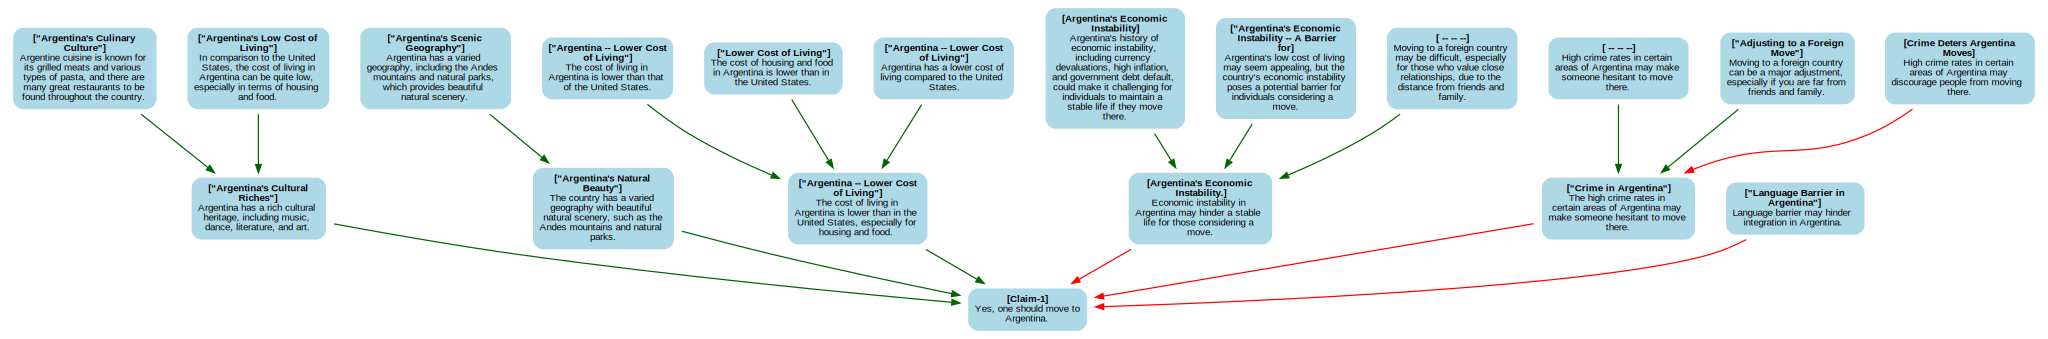

In [ ]:
from IPython.display import SVG, display

svg_argmap = next(art.data for art in results.artifacts if art.id == "svg_argmap")
display(SVG(data=svg_argmap))

In [ ]:
import pandas as pd

table = pd.DataFrame([score.model_dump() for score in results.scores])
table.drop(columns=["metadata", "comment"], inplace=True)
table.rename(columns={"id": "metric id"}, inplace=True)
table

,metric id,description,score
0,argmap_size,Measure the size of the argument map (number o...,21.0
1,argmap_attack_ratio,Ratio of attacking reasons (cons) in the infor...,0.7


### Example Usage 3:<br/>Use a custom model (`transformers`) as expert

In [4]:
config = logikon.DebugConfig(
    expert_model="Open-Orca/OpenOrca-Platypus2-13B", #"Open-Orca/OpenOrca-Platypus2-13B",
    llm_framework="VLLM",
    artifacts=["svg_argmap"],
    metrics=[
        "argmap_size",          # number of reasons
        "argmap_attack_ratio",   # number of cons / number of reasons
    ],
)

In [ ]:
results = logikon.score(prompt, completion, config=config)

<div class="alert alert-block alert-warning">
<b>Limitation.</b> The <code>expert_model</code> based on <i>llama-2-13b</i> is not well-suited to debug reasoning traces. It renders arguments as competing central claims, which is caused by a failure to identify the overarching question. 
</div>

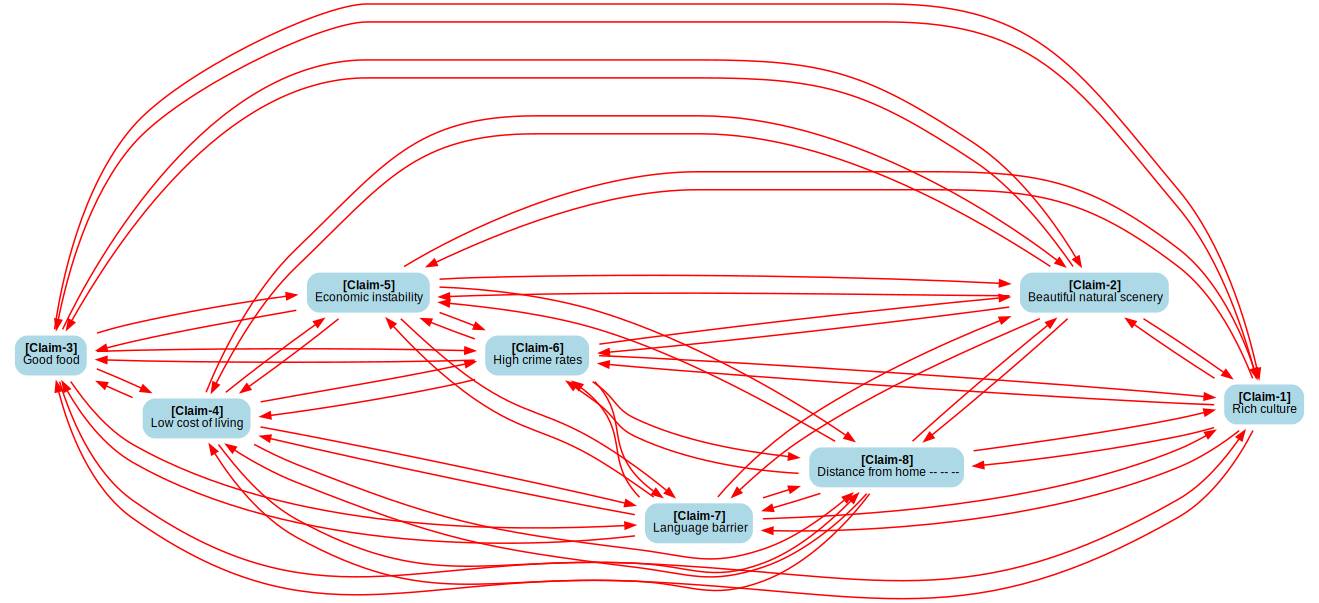

In [7]:
from IPython.display import SVG, display

svg_argmap = next(art.data for art in results.artifacts if art.id == "svg_argmap")
display(SVG(data=svg_argmap))

### Short-term Product Roadmap (as of Sep 23)

* address redundancy issues (alternative holistic debugger for argument mapping involving argdown)
* more visualizations (e.g., argumentative annotation of LLM trace)
* integrations (via `report_to` in `config` and `Callbacks` for LLM agents)
* dashboard and demos for empirical / interactive validations

****

(c) 2023 Logikon AI | License: Apache 2.0